In [8]:
import numpy as np
import pandas as pd
import time
import google.generativeai as genai
from google.api_core.exceptions import ResourceExhausted
import matplotlib.pyplot as plt

c:\Users\shach\.conda\envs\oded2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
# importing interview data
interview_data = pd.read_csv(r"C:\Users\shach\Desktop\פסיכולוגיה\מדעי הנתונים בפסיכולוגיה\עבודה\python\processed_interviews.csv")
interview_data["date"] = pd.to_datetime(interview_data["date"], errors='coerce')
interview_data["content"] = interview_data["content"].apply(lambda x: eval(x))

In [51]:
# filtering interviews that we dont who won
n = len(interview_data)
interview_data = interview_data[interview_data["won"] != 999]
print(n-len(interview_data), " Interviews were removed")
interview_data = interview_data.reset_index(drop=True)

530  Interviews were removed


In [52]:
# in order to not having duplicated players_id
# we will do the filtering for the male and female in separate data frames and then merge them

# importing players basic info
def import_players_info(file_path, sex):
    players_data =  pd.read_csv(file_path)
    players_data["name"] = players_data["name_last"] + ", " + players_data["name_first"]
    players_data["sex"] = sex
    players_data = players_data[players_data["name"].isin(interview_data["name"])]
    return players_data

# importing ranking data to remove players we dont have ranking data on them
def import_ranking_data(file_path_arr):
    ranking_data = pd.DataFrame()
    for file_path in file_path_arr:
        ranking_data = pd.concat([ranking_data, pd.read_csv(file_path)], ignore_index=True)
    return ranking_data

male_players_data = import_players_info(r"C:\Users\shach\Desktop\פסיכולוגיה\מדעי הנתונים בפסיכולוגיה\עבודה\raw files\players\atp_players.csv", "M")
female_players_data = import_players_info(r"C:\Users\shach\Desktop\פסיכולוגיה\מדעי הנתונים בפסיכולוגיה\עבודה\raw files\players\wta_players.csv", "F")

male_ranking_links = ["C:/Users/shach/Desktop/פסיכולוגיה/מדעי הנתונים בפסיכולוגיה/עבודה/raw files/rankings/atp_rankings_90s.csv",
  "C:/Users/shach/Desktop/פסיכולוגיה/מדעי הנתונים בפסיכולוגיה/עבודה/raw files/rankings/atp_rankings_00s.csv",
  "C:/Users/shach/Desktop/פסיכולוגיה/מדעי הנתונים בפסיכולוגיה/עבודה/raw files/rankings/atp_rankings_10s.csv",
  "C:/Users/shach/Desktop/פסיכולוגיה/מדעי הנתונים בפסיכולוגיה/עבודה/raw files/rankings/atp_rankings_70s.csv",
  "C:/Users/shach/Desktop/פסיכולוגיה/מדעי הנתונים בפסיכולוגיה/עבודה/raw files/rankings/atp_rankings_80s.csv",
  "C:/Users/shach/Desktop/פסיכולוגיה/מדעי הנתונים בפסיכולוגיה/עבודה/raw files/rankings/atp_rankings_20s.csv"]
female_ranking_links = ["C:/Users/shach/Desktop/פסיכולוגיה/מדעי הנתונים בפסיכולוגיה/עבודה/raw files/rankings/wta_rankings_90s.csv",
  "C:/Users/shach/Desktop/פסיכולוגיה/מדעי הנתונים בפסיכולוגיה/עבודה/raw files/rankings/wta_rankings_00s.csv",
  "C:/Users/shach/Desktop/פסיכולוגיה/מדעי הנתונים בפסיכולוגיה/עבודה/raw files/rankings/wta_rankings_10s.csv",
  "C:/Users/shach/Desktop/פסיכולוגיה/מדעי הנתונים בפסיכולוגיה/עבודה/raw files/rankings/wta_rankings_80s.csv",
  "C:/Users/shach/Desktop/פסיכולוגיה/מדעי הנתונים בפסיכולוגיה/עבודה/raw files/rankings/wta_rankings_20s.csv"]

male_ranking_data = import_ranking_data(male_ranking_links)
female_ranking_data = import_ranking_data(female_ranking_links)

C:\Users\shach\AppData\Local\Temp\ipykernel_27204\3295365982.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  players_data =  pd.read_csv(file_path)


In [53]:
# removing from players data the players that are not in the rankings
n = len(male_players_data) + len(female_players_data)

male_players_data = male_players_data[male_players_data["player_id"].isin(male_ranking_data["player"])]
female_players_data = female_players_data[female_players_data["player_id"].isin(female_ranking_data["player"])]

# the total number of players removed after the filtering
print(n-len(male_players_data)-len(female_players_data))

5


In [54]:
# checking for duplicates player_id in male and female datasets
for id in male_players_data["player_id"]:
    if ((id == female_players_data["player_id"]).any()):
        print("id " + str(id) + " is in both datasets")
        print("male name: " + male_players_data[male_players_data["player_id"] == id].values[0][8])
        print("female name: " + female_players_data[female_players_data["player_id"] == id].values[0][8])

# now there is only one duplicate id:
# the same id, 200008, for two players
# male: "Galarneau, Alexis"
# female: "Molik, Alicia"
# because we have 34 interviews of Alicia but only 3 of Alexis
# to prevent any confusion, we will remove Alexis from the data

male_players_data = male_players_data.drop(male_players_data[male_players_data["player_id"] == 200008].index)
male_ranking_data = male_ranking_data.drop(male_ranking_data[male_ranking_data["player"] == 200008].index)


id 200008 is in both datasets
male name: Galarneau, Alexis
female name: Molik, Alicia


In [55]:
# now that we dont have duplicates, we can merge the data
players_data = pd.concat([male_players_data, female_players_data])
ranking_data = pd.concat([male_ranking_data, female_ranking_data])

In [56]:
#creating a players dataframe
# basic information from players_data
players_df = pd.DataFrame({
    "id": players_data["player_id"],
    "name": players_data["name"],
    "sex": pd.Categorical(players_data["sex"]),
    "dob": pd.to_datetime(players_data["dob"], format='%Y%m%d'),
    "year": pd.to_datetime(players_data["dob"], format='%Y%m%d').dt.year,
    "month": pd.to_datetime(players_data["dob"], format='%Y%m%d').dt.month,
    "country": players_data["ioc"],
    "hand": pd.Categorical(players_data["hand"]),
    "height": players_data["height"]
})
players_df = players_df.set_index("id")


# adding ranking data
# adding the max rank of each player
players_df["max_rank"] = ranking_data.groupby("player")["rank"].min()

# adding the number of weeks in the max rank
max_rank = ranking_data[ranking_data["rank"] == ranking_data.groupby("player")["rank"].transform('min')]
max_rank = max_rank.groupby("player").count()
players_df["weeks_in_max_rank"] = max_rank["rank"]

# adding number of interviews we have for each player
players_df["interview_count"] = players_df["name"].map(interview_data["name"].value_counts())

# adding the minimum number of interviews won and interviews lost
won = interview_data[interview_data["won"] == 1]
lost = interview_data[interview_data["won"] == 0]
won = won["name"].value_counts()
lost = lost["name"].value_counts()
won_lost = pd.concat([won, lost], axis=1).fillna(0).min(axis=1)
players_df["min_won_lost"] = players_df["name"].map(won_lost)

players_df

,name,sex,dob,year,month,country,hand,height,max_rank,weeks_in_max_rank,interview_count,min_won_lost
id,,,,,,,,,,,,
100029,"Laver, Rod",M,1938-08-09,1938,8,AUS,L,173.0,3,5,4,0.0
100035,"Tiriac, Ion",M,1939-05-09,1939,5,ROU,R,185.0,55,1,1,0.0
100081,"Pasarell, Charlie",M,1944-02-12,1944,2,USA,R,185.0,35,1,1,0.0
100141,"Franulovic, Zeljko",M,1947-06-13,1947,6,CRO,R,NaN,30,1,2,1.0
100253,"Gullikson, Tom",M,1951-09-08,1951,9,USA,L,180.0,34,1,7,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
221247,"Makarova, Ekaterina",F,1996-02-15,1996,2,RUS,R,NaN,168,2,24,8.0
222233,"Stakusic, Marina",F,2004-11-27,2004,11,CAN,R,NaN,258,1,3,0.0
222258,"Fruhvirtova, Linda",F,2005-05-01,2005,5,CZE,R,NaN,49,1,6,2.0


In [2]:
# players that have at least 2 interviews
# this section is because I wanted to check if 3 or 2 interviews are enough to predict the winner
# it later turned out that 2 interviews are better enough (because it's dataset is bigger)
how_many_interviews = 2

(array([57., 67., 78., 48., 40., 27., 29., 14., 20., 16., 16., 18., 25.,
       24., 18., 20., 15., 18., 21.,  9.,  8.,  5.,  9.,  5.]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]), <BarContainer object of 24 artists>)
405


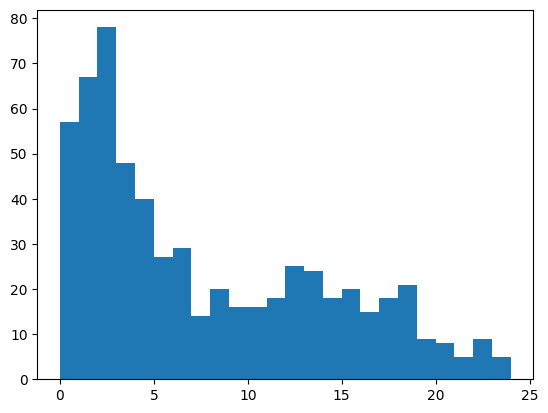

In [58]:
#checking the distribution of the min(won, lost) variable
print(plt.hist(players_df["min_won_lost"], bins=24))

# because i dont want to lose too many players, we will focus on players that have at least 2 interviews that they won and lost
# that means that for each player, we have at least 4 interviews
print(len(players_df[players_df["min_won_lost"]>=how_many_interviews]))

In [59]:
# we will filter the data to include only players that have at least how_many_interviews interviews that they won and lost
n = len(players_df)
players_df = players_df[players_df["min_won_lost"]>=how_many_interviews]
players_df = players_df.reset_index()
print("num of players removed: ", n-len(players_df))

num of players removed:  202


max_rank
1      50
4      32
3      24
2      21
8      17
       ..
834     1
137     1
74      1
44      1
168     1
Name: count, Length: 72, dtype: int64
num of players removed:  30
(array([50., 21., 24., 32., 17., 11., 14., 17., 13., 12., 10., 12.,  8.,
        8.,  8.,  5.,  6., 10.,  9.,  6.,  9.,  7.,  3.,  3.,  4.,  2.,
        6.,  2.,  4.,  1.,  2.,  3.,  3.,  0.,  2.,  1.,  2.,  4.,  6.,
        2.,  2.,  4.,  2.,  1.,  0.,  3.,  0.,  1.,  3.]), array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]), <BarContainer object of 49 artists>)
186  players have max rank <= 8


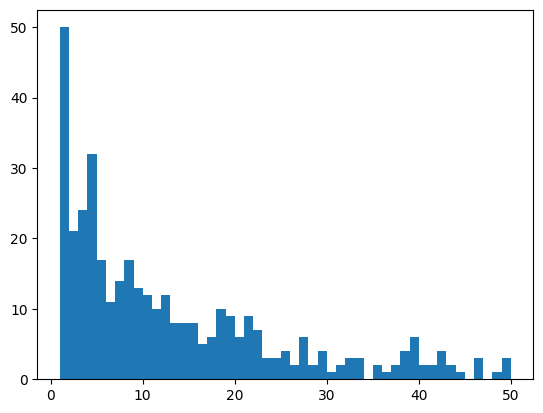

In [60]:
# lets see the distribution of the max rank
print(players_df["max_rank"].value_counts())

# lets drop the players that have max rank above 50
n = len(players_df)
players_df = players_df[players_df["max_rank"] <= 50]
print("num of players removed: ", n-len(players_df))

# lets see the distribution of the max rank again
print(plt.hist(players_df["max_rank"], bins=49))
print(len(players_df[players_df["max_rank"] <= 8]), " players have max rank <= 8")

# we will split the players to 2 groups:
# top players: max rank <= 8
# other players: max rank > 8

players_df = players_df.reset_index(drop=True)

In [61]:
# function that gets the name, interview_data and if we want won\lost and returns the first (earliest) interviews
def get_interviews(name, interview_data, won_lost):
    first_interview = interview_data[(interview_data["name"] == name) & (interview_data["won"] == won_lost)].sort_values(by="date")["interview"].iloc[0]
    second_interview = interview_data[(interview_data["name"] == name) & (interview_data["won"] == won_lost)].sort_values(by="date")["interview"].iloc[1]
    if how_many_interviews == 3:
        third_interview = interview_data[(interview_data["name"] == name) & (interview_data["won"] == won_lost)].sort_values(by="date")["interview"].iloc[2]
        if won_lost == 1:
            first_interview = "INTERVIEW 1: " + first_interview + "\n"
            second_interview = "INTERVIEW 2: " + second_interview + "\n"
            third_interview = "INTERVIEW 3: " + third_interview + "\n"
        else:
            first_interview = "INTERVIEW 4: " + first_interview + "\n"
            second_interview = "INTERVIEW 5: " + second_interview + "\n"
            third_interview = "INTERVIEW 6: " + third_interview + "\n"
        return first_interview + second_interview + third_interview
    if how_many_interviews == 2:
        if won_lost == 1:
            first_interview = "INTERVIEW 1: " + first_interview + "\n"
            second_interview = "INTERVIEW 2: " + second_interview + "\n"
        else:
            first_interview = "INTERVIEW 3: " + first_interview + "\n"
            second_interview = "INTERVIEW 4: " + second_interview + "\n"
        return first_interview + second_interview

# we will add a column for won and lost interviews
# the won [lost] column will be the first (earliest) interview that the player won [lost]
players_df["interviews"] = players_df["name"].apply(lambda x: get_interviews(x, interview_data, 1) + get_interviews(x, interview_data, 0))
players_df

,id,name,sex,dob,year,month,country,hand,height,max_rank,weeks_in_max_rank,interview_count,min_won_lost,interviews
0,100581,"McEnroe, John",M,1959-02-16,1959,2,USA,L,180.0,1,136,6,3.0,"INTERVIEW 1: Q. John, almost everybody that h..."
1,100644,"Zverev, Alexander",M,1997-04-20,1997,4,GER,R,198.0,2,11,45,13.0,"INTERVIEW 1: THE MODERATOR:Â Questions, please..."
2,100656,"Lendl, Ivan",M,1960-03-07,1960,3,USA,R,188.0,1,228,10,4.0,INTERVIEW 1: Q. You only lost a couple of set...
3,101062,"Wilander, Mats",M,1964-08-22,1964,8,SWE,R,183.0,1,16,9,3.0,"INTERVIEW 1: Q. Mats, when you were talking a..."
4,101098,"Forget, Guy",M,1965-01-04,1965,1,FRA,L,190.0,4,4,9,4.0,"INTERVIEW 1: Q. Guy, after you were up 6-1, 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,216347,"Swiatek, Iga",F,2001-05-31,2001,5,POL,R,176.0,1,79,45,9.0,"INTERVIEW 1: THE MODERATOR: Questions, please...."
371,220367,"Fernandez, Leylah",F,2002-09-06,2002,9,CAN,L,168.0,13,1,36,13.0,"INTERVIEW 1: THE MODERATOR: Questions, please...."
372,221054,"Raducanu, Emma",F,2002-11-13,2002,11,GBR,R,175.0,10,5,43,17.0,"INTERVIEW 1: THE MODERATOR: Questions, please...."
373,221103,"Gauff, Coco",F,2004-03-13,2004,3,USA,R,175.0,3,15,44,11.0,"INTERVIEW 1: THE MODERATOR: Questions, please...."


In [21]:
# exporting the data to csv
players_df.to_csv("players_df"+str(how_many_interviews)+".csv", index=False)

In [3]:
# importing the csv files
players_df = pd.read_csv("players_df"+str(how_many_interviews)+".csv")
players_df

,id,name,sex,dob,year,month,country,hand,height,max_rank,...,O5,C5,E5,A5,N5,confi,will,concer,persis,comp
0,100253,"Gullikson, Tom",M,1951-09-08,1951,9,USA,L,180.0,34,...,2,6,5.0,4,3.0,6.0,9.0,8.0,9.0,9.0
1,100581,"McEnroe, John",M,1959-02-16,1959,2,USA,L,180.0,1,...,5,5,3.0,5,5.0,8.0,8.0,7.0,9.0,8.0
2,100644,"Zverev, Alexander",M,1997-04-20,1997,4,GER,R,198.0,2,...,6,9,6.0,7,6.0,7.0,7.0,6.0,8.0,8.0
3,100656,"Lendl, Ivan",M,1960-03-07,1960,3,USA,R,188.0,1,...,7,9,8.0,8,6.0,8.0,9.0,8.0,9.0,8.0
4,100923,"Masur, Wally",M,1963-05-13,1963,5,AUS,R,180.0,15,...,2,9,8.0,9,6.0,8.0,9.0,10.0,10.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,221054,"Raducanu, Emma",F,2002-11-13,2002,11,GBR,R,175.0,10,...,7,8,7.0,8,5.0,9.0,9.0,9.0,8.0,9.0
424,221103,"Gauff, Coco",F,2004-03-13,2004,3,USA,R,175.0,3,...,9,9,8.0,8,6.0,8.0,5.0,9.0,9.0,9.0
425,222258,"Fruhvirtova, Linda",F,2005-05-01,2005,5,CZE,R,NaN,49,...,7,8,7.0,8,5.0,9.0,9.0,9.0,9.0,9.0
426,222328,"Noskova, Linda",F,2004-11-17,2004,11,CZE,R,NaN,40,...,7,8,7.0,7,2.0,7.0,9.0,8.0,8.0,5.0


In [102]:
from fuzzywuzzy import fuzz

# checks if a word is similiar enough to the name of the player
def is_name_in_word(name, word, threshold=80):
    # Calculate the similarity ratio
    similarity_ratio = fuzz.partial_ratio(name, word)
    return similarity_ratio >= threshold

# returning the name in the format of the interviews
cap_names_exceptions = {"Gambill, Jan Michael": "JAN-MICHAEL GAMBILL",
                    "Roger-Vasselin, Edouard": "EDOUARD ROGER‑VASSELIN",
                    "Wawrinka, Stan": "STANISLAS WAWRINKA",
                    "Murray, Andy": "ANDREW MURRAY",
                    "Zvereva, Natalia": "NATASHA ZVEREVA",
                    "Garrison, Zina": "ZINA GARRISON-JACKSON",
                    "Date Krumm, Kimiko": "KIMIKO DATE"
                    }
def get_caped_name(name):
    if name in cap_names_exceptions:
        return cap_names_exceptions[name]
    caped_name = name.split(", ")
    if caped_name[0].startswith("Mc"):
        return caped_name[1].upper() + " Mc" + caped_name[0][2:].upper()
    caped_name = " ".join([caped_name[1], caped_name[0]])
    return caped_name.upper()

# replacing the name in the interview with "SPEAKER"
def replace_name_in_interviews(name, interview):
    split_interview = interview.split(" ")
    split_interview = list(map(lambda x: "SPEAKER:" if is_name_in_word(get_caped_name(name), x) and x.upper()==x and len(x)>1 else x, split_interview))
    return " ".join(split_interview)

answer_name_exceptions = ["ALBERTO COSTA", "VINCE SPADEA", "LUKAS POUILLE", "SILVIA FARINA", "MADISON KEYES"]
# getting the interview and returning only the speaker's answers
def return_only_speakers_answers(interview, name):
    interview = replace_name_in_interviews(name, interview).split(" ")
    speaker_answers = []
    speaker_line = False
    for word in interview:
        cleaned_word = word.replace("Â", "")
        if cleaned_word in ["SPEAKER:", "SPEAKER", "SPEAKER."] and cleaned_word != "":
            speaker_line = True
        elif cleaned_word.isupper() and cleaned_word not in [" ", "I", ","]:
            speaker_line = False
        if speaker_line and cleaned_word not in ["SPEAKER:", "SPEAKER", "SPEAKER."]:
            speaker_answers.append(cleaned_word)
    return " ".join(speaker_answers)

# checking if the response of gemini is valid
def check_response(response):
    response = response.replace(" ", "")
    response = response.split(",")
    if len(response) != 5 or any(x in ["None", "nan", None] for x in response):
        return False
    try:
        response = [int(float(x)) for x in response]
    except ValueError:
        return False
    for i in range(5):
        if not 1<=response[i]<=10:
            return False
    return True

# names of players that the response in the interviews is not filled\ valid
def not_filled_names_list(condition):
    if condition:
        return players_df[~players_df.apply(lambda row: check_response(",".join([str(val) if val is not None else '' for val in row[["O5", "C5", "E5", "A5", "N5"]]])), axis=1)]["name"]
    else:
        return players_df[~players_df.apply(lambda row: check_response(",".join([str(val) if val is not None else '' for val in row[["confi","will", "concer", "persis", "comp"]]])), axis=1)]["name"]


In [ ]:
# adding a column with only the players answers for the LIWC
players_df["answers"] = players_df.apply(lambda x: return_only_speakers_answers(x["interviews"], x["name"]), axis=1)

# lets also add a column for the ratio of answers to whole interview to see if how much "hofer" the player has a predictive power
players_df["answers_ratio"] = players_df.apply(lambda x: len(x["answers"])/len(x["interviews"]), axis=1)
players_df

In [66]:
# exporting the answers data to csv to use LIWC
players_df[["name", "answers"]].to_csv(r"C:\Users\shach\Desktop\פסיכולוגיה\מדעי הנתונים בפסיכולוגיה\עבודה\python\LIWC\players_answers"+str(how_many_interviews)+".csv", index=False)

In [114]:
### big 5\ personality traits

# True = big 5, False = personality traits: self confidence, will to win, concentration, persistence and competitiveness
condition = False

In [115]:
# adding collumns to the players dataframe
if condition:
    players_df[["O5", "C5", "E5", "A5", "N5"]] = None
else:
    players_df[["confi","will", "concer", "persis", "comp"]] = None
players_df

,id,name,sex,dob,year,month,country,hand,height,max_rank,...,O5,C5,E5,A5,N5,confi,will,concer,persis,comp
0,100253,"Gullikson, Tom",M,1951-09-08,1951,9,USA,L,180.0,34,...,2,6,5,4,3,None,None,None,None,None
1,100581,"McEnroe, John",M,1959-02-16,1959,2,USA,L,180.0,1,...,5,5,3,5,5,None,None,None,None,None
2,100644,"Zverev, Alexander",M,1997-04-20,1997,4,GER,R,198.0,2,...,6,9,6,7,6,None,None,None,None,None
3,100656,"Lendl, Ivan",M,1960-03-07,1960,3,USA,R,188.0,1,...,7,9,8,8,6,None,None,None,None,None
4,100923,"Masur, Wally",M,1963-05-13,1963,5,AUS,R,180.0,15,...,2,9,8,9,6,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,221054,"Raducanu, Emma",F,2002-11-13,2002,11,GBR,R,175.0,10,...,7,8,7,8,5,None,None,None,None,None
424,221103,"Gauff, Coco",F,2004-03-13,2004,3,USA,R,175.0,3,...,9,9,8,8,6,None,None,None,None,None
425,222258,"Fruhvirtova, Linda",F,2005-05-01,2005,5,CZE,R,NaN,49,...,7,8,7,8,5,None,None,None,None,None
426,222328,"Noskova, Linda",F,2004-11-17,2004,11,CZE,R,NaN,40,...,7,8,7,7,2,None,None,None,None,None


In [116]:
# importing promt
if condition:
    link = r"C:\Users\shach\Desktop\פסיכולוגיה\מדעי הנתונים בפסיכולוגיה\עבודה\python\promts\big 5 promt.txt"
else:
    link = r"C:\Users\shach\Desktop\פסיכולוגיה\מדעי הנתונים בפסיכולוגיה\עבודה\python\promts\personallity traits promt.txt"

with open(link, 'r') as file:
    basic_promt = file.read()
basic_promt

"You are a world-renowned expert psychologist. You have a long background in researching human psychology and evaluating personality traits.\nYour task is to rate each of this following psychological traits on a scale of 1 to 10, where 1 is very low and 10 is very high, based on the speaker's answers in the interviews: self confidence, will to win, concentration, persistence and competitiveness.\n\n\nDefinitions of the traits:\nSelf-confidence is a person's belief in their own abilities, skills, and judgment. It reflects the trust they have in themselves to successfully accomplish tasks, make decisions, and handle challenges.\nWill to win refers to a strong and persistent desire or determination to achieve victory or success, often despite obstacles or challenges. It involves a mindset of perseverance, focus, and relentless effort to reach a goal, especially in competitive or high-pressure situations. The will to win is characterized by resilience, mental toughness, and a commitment to

In [ ]:
from tqdm import tqdm

#GOOGLE_API_KEY = "your API key goes here" 
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel('gemini-1.5-flash')
#model = genai.GenerativeModel('gemini-1.0-pro')

# asking the model to rate the big 5 personality traits of the players given the interviews
not_filled_names = not_filled_names_list(condition)
for name in tqdm(not_filled_names):
    j = 0
    bool = False # Check if the response is valid
    while j < 3 and not bool:
        j += 1
        try:
            if j > 1:
                response = model.generate_content(basic_promt + "\n" + replace_name_in_interviews(name, players_df[players_df["name"] == name]["interviews"].values[0]) + "\n" +"END OF INTEVIEWS \n Make sure your answer is in the format of 5 digits separated by commas")
            else:
                response = model.generate_content(basic_promt + "\n" + replace_name_in_interviews(name, players_df[players_df["name"] == name]["interviews"].values[0]) + "\n")
        except ResourceExhausted:
            print("     ResourceExhausted error, retrying in 1 minute...")
            time.sleep(60) # Wait for 1 minute before retrying
            continue
        if response.candidates[0].finish_reason != 3:
            response.text
            bool = check_response(response.text)
            if not bool:
                print("error number " + str(j) + " with " + name)
                print("the response was ", response.text)
        else:
            print(get_caped_name(name), " Response blocked due to safety ratings.")
            break
        
    if bool:
        if condition:
            players_df.loc[players_df["name"] == name, ["O5", "C5", "E5", "A5", "N5"]] = response.text.split(",")
        else:
            players_df.loc[players_df["name"] == name, ["confi", "will", "concer", "persis", "comp"]] = response.text.split(",")


 50%|█████     | 1/2 [00:01<00:01,  1.67s/it]

THOMAS MUSTER  Response blocked due to safety ratings.


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

DOMINIK KOEPFER  Response blocked due to safety ratings.


In [125]:
if condition:
    players_df["N5"] = players_df["N5"].str.replace("\n", "")
else:
    players_df["comp"] = players_df["comp"].str.replace("\n", "")
players_df

,id,name,sex,dob,year,month,country,hand,height,max_rank,...,O5,C5,E5,A5,N5,confi,will,concer,persis,comp
0,100253,"Gullikson, Tom",M,1951-09-08,1951,9,USA,L,180.0,34,...,2,6,5,4,3,6,9,8,9,9
1,100581,"McEnroe, John",M,1959-02-16,1959,2,USA,L,180.0,1,...,5,5,3,5,5,8,8,7,9,8
2,100644,"Zverev, Alexander",M,1997-04-20,1997,4,GER,R,198.0,2,...,6,9,6,7,6,7,7,6,8,8
3,100656,"Lendl, Ivan",M,1960-03-07,1960,3,USA,R,188.0,1,...,7,9,8,8,6,8,9,8,9,8
4,100923,"Masur, Wally",M,1963-05-13,1963,5,AUS,R,180.0,15,...,2,9,8,9,6,8,9,10,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,221054,"Raducanu, Emma",F,2002-11-13,2002,11,GBR,R,175.0,10,...,7,8,7,8,5,9,9,9,8,9
424,221103,"Gauff, Coco",F,2004-03-13,2004,3,USA,R,175.0,3,...,9,9,8,8,6,8,5,9,9,9
425,222258,"Fruhvirtova, Linda",F,2005-05-01,2005,5,CZE,R,NaN,49,...,7,8,7,8,5,9,9,9,9,9
426,222328,"Noskova, Linda",F,2004-11-17,2004,11,CZE,R,NaN,40,...,7,8,7,7,2,7,9,8,8,5


In [126]:
# exporting the data to csv
players_df.to_csv("players_df"+str(how_many_interviews)+".csv", index=False)

In [18]:
# importing players_df
how_many_interviews = 3
players_df = pd.read_csv("players_df"+str(how_many_interviews)+".csv")
players_df

,id,name,sex,dob,year,month,country,hand,height,max_rank,...,O5,C5,E5,A5,N5,confi,will,concer,persis,comp
0,100581,"McEnroe, John",M,1959-02-16,1959,2,USA,L,180.0,1,...,7,8,9,4,6,7.0,8.0,7.0,9.0,7.0
1,100644,"Zverev, Alexander",M,1997-04-20,1997,4,GER,R,198.0,2,...,3,4,3,2,2,8.0,9.0,7.0,8.0,9.0
2,100656,"Lendl, Ivan",M,1960-03-07,1960,3,USA,R,188.0,1,...,8,6,7,4,3,8.0,7.0,7.0,9.0,NaN
3,101062,"Wilander, Mats",M,1964-08-22,1964,8,SWE,R,183.0,1,...,8,9,6,9,4,7.0,8.0,4.0,9.0,NaN
4,101098,"Forget, Guy",M,1965-01-04,1965,1,FRA,L,190.0,4,...,7,5,6,7,5,4.0,9.0,6.0,9.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,216347,"Swiatek, Iga",F,2001-05-31,2001,5,POL,R,176.0,1,...,7,3,6,8,5,8.0,9.0,7.0,10.0,8.0
371,220367,"Fernandez, Leylah",F,2002-09-06,2002,9,CAN,L,168.0,13,...,3,7,3,7,8,7.0,8.0,6.0,9.0,9.0
372,221054,"Raducanu, Emma",F,2002-11-13,2002,11,GBR,R,175.0,10,...,8,7,7,9,9,8.0,9.0,7.0,10.0,8.0
373,221103,"Gauff, Coco",F,2004-03-13,2004,3,USA,R,175.0,3,...,9,9,8,9,8,8.0,9.0,8.0,7.0,9.0


In [20]:
### LIWC

summary_variables = ["Analytic", "Clout", "Authentic", "Tone"]
linguistic_dimensions = ["function", "pronoun", "ppron", "i", "we", "you", "shehe", "they"]
drives = ["Drives", "affiliation", "achieve", "power"]
cognition = ["allnone"]
affect = ["tone_pos", "tone_neg", "emotion", "emo_pos", "emo_neg", "emo_anx", "emo_anger", "emo_sad"]
social_behavior = ["prosocial", "polite", "conflict", "comm"]
social_referents = ["family", "friend"]
physical = ["health", "illness", "wellness", "mental"]
states = ["need", "want", "acquire", "lack", "fulfill", "fatigue"]
motives = ["reward", "risk", "curiosity", "allure"]
time_orientation = ["time", "focuspast", "focuspresent", "focusfuture"]
cols_to_import = ["name"] + summary_variables + linguistic_dimensions + drives + cognition + affect + social_behavior + social_referents + physical + states + motives + time_orientation

liwc_df = pd.read_csv(r"C:\Users\shach\Desktop\פסיכולוגיה\מדעי הנתונים בפסיכולוגיה\עבודה\python\LIWC\LIWC-22 Results - players_answers"+str(how_many_interviews)+" - LIWC Analysis.csv",
                      usecols=cols_to_import)

# adding "LIWC" to all the columns names except for the name
new_columns_names = ["name"] + list(map(lambda x: "LIWC_" + x, liwc_df.columns[1:]))
liwc_df.columns = new_columns_names

liwc_df

,name,LIWC_Analytic,LIWC_Clout,LIWC_Authentic,LIWC_Tone,LIWC_function,LIWC_pronoun,LIWC_ppron,LIWC_i,LIWC_we,...,LIWC_fulfill,LIWC_fatigue,LIWC_reward,LIWC_risk,LIWC_curiosity,LIWC_allure,LIWC_time,LIWC_focuspast,LIWC_focuspresent,LIWC_focusfuture
0,"McEnroe, John",13.81,14.33,64.86,67.03,66.72,20.29,12.35,6.75,0.50,...,0.15,0.03,0.36,0.18,0.09,8.51,3.40,4.80,8.22,2.32
1,"Zverev, Alexander",11.41,10.56,92.33,86.29,65.32,21.43,15.72,9.97,1.09,...,0.10,0.07,0.40,0.20,0.00,9.08,4.33,6.01,6.64,1.55
2,"Lendl, Ivan",6.27,9.99,83.35,62.74,68.06,20.87,12.60,6.92,0.31,...,0.17,0.09,0.66,0.24,0.12,8.53,5.73,5.80,6.63,2.37
3,"Wilander, Mats",11.90,2.84,93.99,84.73,65.37,19.12,12.78,9.12,0.11,...,0.16,0.07,0.60,0.23,0.09,9.65,5.16,3.70,7.58,1.76
4,"Forget, Guy",11.69,23.54,71.33,75.01,67.42,19.55,13.53,7.12,0.35,...,0.11,0.09,0.40,0.33,0.11,9.40,5.23,5.76,5.49,2.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,"Swiatek, Iga",3.60,1.00,96.56,89.07,65.22,21.75,15.61,12.56,0.90,...,0.00,0.12,0.43,0.16,0.12,10.92,4.50,6.10,7.20,3.56
371,"Fernandez, Leylah",16.48,6.56,85.56,92.95,64.45,21.08,15.00,11.25,1.00,...,0.13,0.10,0.79,0.16,0.16,8.36,4.30,6.90,4.96,2.12
372,"Raducanu, Emma",14.97,6.48,92.59,90.63,64.30,21.80,15.54,11.44,0.48,...,0.06,0.00,0.42,0.10,0.10,8.94,4.35,6.19,5.86,1.87
373,"Gauff, Coco",12.34,2.83,92.61,67.33,64.27,21.02,14.25,10.95,0.70,...,0.07,0.00,0.33,0.18,0.15,9.78,4.02,5.87,6.90,1.50


In [21]:
# adding liwc cols to players_df
players_df = pd.merge(players_df, liwc_df, on="name")
players_df

,id,name,sex,dob,year,month,country,hand,height,max_rank,...,LIWC_fulfill,LIWC_fatigue,LIWC_reward,LIWC_risk,LIWC_curiosity,LIWC_allure,LIWC_time,LIWC_focuspast,LIWC_focuspresent,LIWC_focusfuture
0,100581,"McEnroe, John",M,1959-02-16,1959,2,USA,L,180.0,1,...,0.15,0.03,0.36,0.18,0.09,8.51,3.40,4.80,8.22,2.32
1,100644,"Zverev, Alexander",M,1997-04-20,1997,4,GER,R,198.0,2,...,0.10,0.07,0.40,0.20,0.00,9.08,4.33,6.01,6.64,1.55
2,100656,"Lendl, Ivan",M,1960-03-07,1960,3,USA,R,188.0,1,...,0.17,0.09,0.66,0.24,0.12,8.53,5.73,5.80,6.63,2.37
3,101062,"Wilander, Mats",M,1964-08-22,1964,8,SWE,R,183.0,1,...,0.16,0.07,0.60,0.23,0.09,9.65,5.16,3.70,7.58,1.76
4,101098,"Forget, Guy",M,1965-01-04,1965,1,FRA,L,190.0,4,...,0.11,0.09,0.40,0.33,0.11,9.40,5.23,5.76,5.49,2.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,216347,"Swiatek, Iga",F,2001-05-31,2001,5,POL,R,176.0,1,...,0.00,0.12,0.43,0.16,0.12,10.92,4.50,6.10,7.20,3.56
371,220367,"Fernandez, Leylah",F,2002-09-06,2002,9,CAN,L,168.0,13,...,0.13,0.10,0.79,0.16,0.16,8.36,4.30,6.90,4.96,2.12
372,221054,"Raducanu, Emma",F,2002-11-13,2002,11,GBR,R,175.0,10,...,0.06,0.00,0.42,0.10,0.10,8.94,4.35,6.19,5.86,1.87
373,221103,"Gauff, Coco",F,2004-03-13,2004,3,USA,R,175.0,3,...,0.07,0.00,0.33,0.18,0.15,9.78,4.02,5.87,6.90,1.50


In [22]:
# exporting the data to csv
players_df.to_csv("players_df"+str(how_many_interviews)+".csv", index=False)